In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
import segmentation_models_pytorch as smp
from torchmetrics import JaccardIndex
import numpy as np
from torchvision.transforms import InterpolationMode
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Задача 1

Обучите модель u-net семантической сегментации на встроенном в torchvision датасете Pascal VOC с VGG в качестве энкодера

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tfms_img = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

tfms_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
    transforms.Lambda(lambda pic: torch.from_numpy(np.array(pic, dtype=np.int64)))
])

root = 'data'
train_ds = VOCSegmentation(
    root, year='2012', image_set='train', download=True,
    transform=tfms_img,
    target_transform=tfms_mask
)
val_ds = VOCSegmentation(
    root, year='2012', image_set='val', download=False,
    transform=tfms_img,
    target_transform=tfms_mask
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

model = smp.Unet(
    encoder_name='vgg16_bn',
    encoder_weights='imagenet',
    in_channels=3,
    classes=21,
    activation=None
).to(device)

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


In [3]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
miou_metric = JaccardIndex(task='multiclass', num_classes=21, ignore_index=255).to(device)

def train_epoch():
    model.train()
    total_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(train_loader.dataset)

def validate_epoch():
    model.eval()
    total_loss = 0.0
    miou_metric.reset()
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item() * imgs.size(0)
            preds_labels = preds.argmax(dim=1)
            miou_metric.update(preds_labels, masks)
    mean_iou = miou_metric.compute().item()
    return total_loss / len(val_loader.dataset), mean_iou

num_epochs = 20
best_val_miou = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    val_loss, val_miou = validate_epoch()
    print(f'[Epoch {epoch}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mIoU: {val_miou:.4f}')
    if val_miou > best_val_miou:
        best_val_miou = val_miou

[Epoch 1/20] Train Loss: 2.1186 | Val Loss: 1.3697 | Val mIoU: 0.1059
[Epoch 2/20] Train Loss: 1.1663 | Val Loss: 0.9280 | Val mIoU: 0.1024
[Epoch 3/20] Train Loss: 0.8589 | Val Loss: 0.8408 | Val mIoU: 0.1022
[Epoch 4/20] Train Loss: 0.7285 | Val Loss: 0.7542 | Val mIoU: 0.1181
[Epoch 5/20] Train Loss: 0.6414 | Val Loss: 0.6900 | Val mIoU: 0.1251
[Epoch 6/20] Train Loss: 0.5853 | Val Loss: 0.6960 | Val mIoU: 0.1817
[Epoch 7/20] Train Loss: 0.5562 | Val Loss: 0.6529 | Val mIoU: 0.1614
[Epoch 8/20] Train Loss: 0.5003 | Val Loss: 0.6436 | Val mIoU: 0.2417
[Epoch 9/20] Train Loss: 0.4551 | Val Loss: 0.6135 | Val mIoU: 0.2578
[Epoch 10/20] Train Loss: 0.4269 | Val Loss: 0.6236 | Val mIoU: 0.2775
[Epoch 11/20] Train Loss: 0.3989 | Val Loss: 0.6275 | Val mIoU: 0.2893
[Epoch 12/20] Train Loss: 0.3668 | Val Loss: 0.5629 | Val mIoU: 0.3091
[Epoch 13/20] Train Loss: 0.3331 | Val Loss: 0.5584 | Val mIoU: 0.3441
[Epoch 14/20] Train Loss: 0.3364 | Val Loss: 0.5946 | Val mIoU: 0.3404
[Epoch 15/20] T

# Задача 2

Обучите модель u-net семантической сегментации на встроенном в torchvision датасете Pascal VOC с ResNet в качестве энкодера

In [3]:
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=21,
    activation=None
).to(device)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [3]:
model = smp.Unet(
    encoder_name='resnet101',
    encoder_weights='imagenet',
    in_channels=3,
    classes=21,
    activation=None
).to(device)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
miou_metric = JaccardIndex(task='multiclass', num_classes=21, ignore_index=255).to(device)

def train_epoch():
    model.train()
    total_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(train_loader.dataset)

def validate_epoch():
    model.eval()
    total_loss = 0.0
    miou_metric.reset()
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item() * imgs.size(0)
            preds_labels = preds.argmax(dim=1)
            miou_metric.update(preds_labels, masks)
    mean_iou = miou_metric.compute().item()
    return total_loss / len(val_loader.dataset), mean_iou

num_epochs = 100
best_val_miou = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    val_loss, val_miou = validate_epoch()
    print(f'[Epoch {epoch}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mIoU: {val_miou:.4f}')
    if val_miou > best_val_miou:
        best_val_miou = val_miou

[Epoch 1/100] Train Loss: 1.4820 | Val Loss: 1.1311 | Val mIoU: 0.1290


In [4]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
miou_metric = JaccardIndex(task='multiclass', num_classes=21, ignore_index=255).to(device)

def train_epoch():
    model.train()
    total_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(train_loader.dataset)

def validate_epoch():
    model.eval()
    total_loss = 0.0
    miou_metric.reset()
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item() * imgs.size(0)
            preds_labels = preds.argmax(dim=1)
            miou_metric.update(preds_labels, masks)
    mean_iou = miou_metric.compute().item()
    return total_loss / len(val_loader.dataset), mean_iou

num_epochs = 20
best_val_miou = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    val_loss, val_miou = validate_epoch()
    print(f'[Epoch {epoch}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mIoU: {val_miou:.4f}')
    if val_miou > best_val_miou:
        best_val_miou = val_miou

[Epoch 1/20] Train Loss: 2.2552 | Val Loss: 1.5507 | Val mIoU: 0.1053
[Epoch 2/20] Train Loss: 1.2309 | Val Loss: 0.9584 | Val mIoU: 0.1745
[Epoch 3/20] Train Loss: 0.8465 | Val Loss: 0.7503 | Val mIoU: 0.2111
[Epoch 4/20] Train Loss: 0.7057 | Val Loss: 0.6912 | Val mIoU: 0.2228
[Epoch 5/20] Train Loss: 0.6150 | Val Loss: 0.6228 | Val mIoU: 0.2457
[Epoch 6/20] Train Loss: 0.5559 | Val Loss: 0.6048 | Val mIoU: 0.2399
[Epoch 7/20] Train Loss: 0.4875 | Val Loss: 0.6122 | Val mIoU: 0.2667
[Epoch 8/20] Train Loss: 0.4515 | Val Loss: 0.5886 | Val mIoU: 0.3420
[Epoch 9/20] Train Loss: 0.4193 | Val Loss: 0.5521 | Val mIoU: 0.3799
[Epoch 10/20] Train Loss: 0.3738 | Val Loss: 0.5561 | Val mIoU: 0.3864
[Epoch 11/20] Train Loss: 0.3327 | Val Loss: 0.5520 | Val mIoU: 0.4181
[Epoch 12/20] Train Loss: 0.2976 | Val Loss: 0.5499 | Val mIoU: 0.4406
[Epoch 13/20] Train Loss: 0.2677 | Val Loss: 0.5402 | Val mIoU: 0.4689
[Epoch 14/20] Train Loss: 0.2840 | Val Loss: 0.6185 | Val mIoU: 0.4218
[Epoch 15/20] T

# Задача 3

Реализуйте семантическую сегментацию на предобученной Yolo


image 1/1 /home/danya/Рабочий стол/Финашка/Машинное зрение/data/street.webp: 320x640 11 persons, 7 cars, 1 truck, 1 handbag, 10.9ms
Speed: 0.8ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


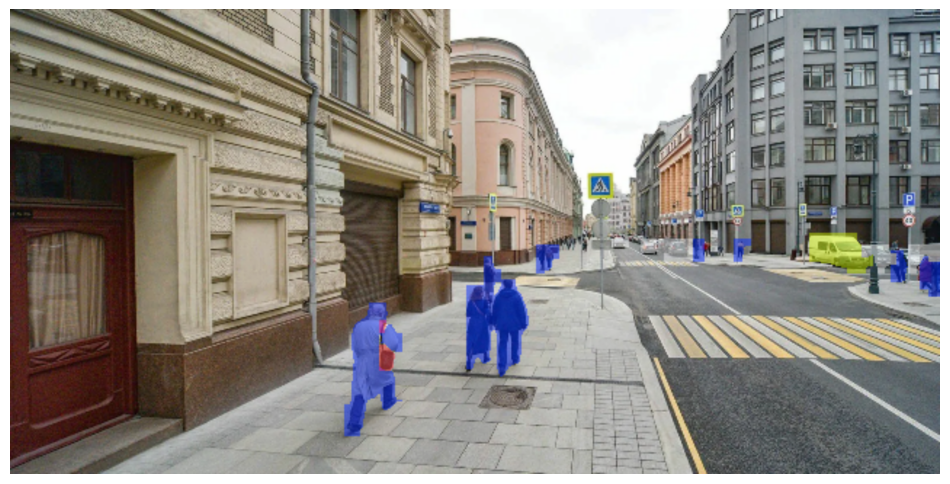

In [20]:
model = YOLO('yolov9e-seg.pt')  

results = model('data/street.webp', task='segment')

img_with_masks = results[0].plot(boxes=False, labels=False) 

plt.figure(figsize=(12, 12))
plt.imshow(img_with_masks[..., ::-1]) 
plt.axis("off")
plt.show()